# Dataset Fast Food Classification

On récupère ce dataset depuis kaggle. 

In [47]:
!pip install tensorflow matplotlib numpy kaggle
# !pip install tensorflow-metal

On commence par créer notre dataset d'entrainement (10 500 images, 70%) et notre dataset de test (4 500 images, 30%)
Le dataset contient 10 classes correspondantes à 10 plats de fast-food différents (burger, frites, donut, ...)

In [ ]:
import kaggle
try: 
    from google.colab import files
    
    uploaded = files.upload()
    
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

except:
    print("Skipping google colab part")
  
kaggle.api.authenticate() # Need kaggle.json in home directory

kaggle.api.dataset_download_files('fast-food-classification-dataset', path='./fastfooddataset', unzip=True)

In [1]:
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import deserialize_keras_object

# Set the path to your dataset
dataset_path = './fastfooddataset/train'

# Define the image size and batch size
image_size = (224, 224)
batch_size = 100

# Use ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
    validation_split=0.3  # Split the data into training and validation sets
)

# Load the training dataset
train_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' for binary classification
    subset='training'  # Specify that this is the training set
)

# Load the validation dataset
validation_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' for binary classification
    subset='validation'  # Specify that this is the validation set
)

# Print class indices
print("Class Indices:", train_dataset.class_indices)

# Now you can use train_dataset and validation_dataset in your model training


Found 10500 images belonging to 10 classes.
Found 4500 images belonging to 10 classes.
Class Indices: {'Baked Potato': 0, 'Burger': 1, 'Crispy Chicken': 2, 'Donut': 3, 'Fries': 4, 'Hot Dog': 5, 'Pizza': 6, 'Sandwich': 7, 'Taco': 8, 'Taquito': 9}


Affichage de quelques images du dataset

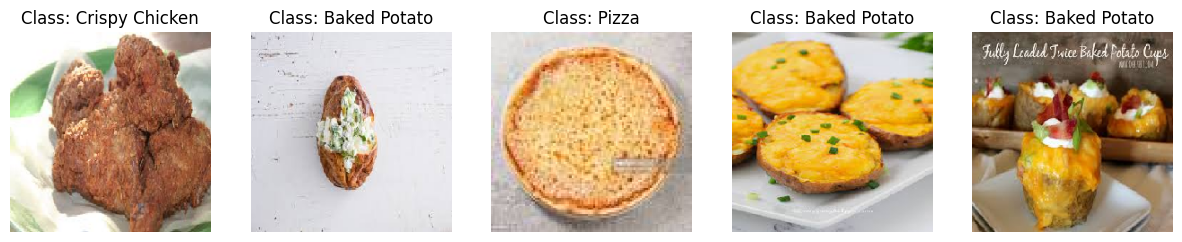

In [2]:
import matplotlib.pyplot as plt
import numpy as np

batch_images, batch_labels = next(train_dataset)

num_images_to_display = 5

# Extract a few images and their labels from the batch
sample_images = batch_images[:num_images_to_display]
sample_labels = batch_labels[:num_images_to_display]

# Define a function to convert one-hot encoded labels to class indices
def one_hot_to_index(one_hot_labels):
    return np.argmax(one_hot_labels, axis=-1)

# Convert one-hot encoded labels to class indices
sample_indices = one_hot_to_index(sample_labels)

# Get class names (assuming your dataset has class names)
class_names = list(train_dataset.class_indices.keys())

# Display the images with class labels
plt.figure(figsize=(15, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {class_names[sample_indices[i]]}")
    plt.axis("off")

plt.show()

Création d'un modèle. 
On prend pour commencer une architecture de CNN classique, en général adaptée à la classification d'images.

In [3]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    [        
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ]
)



2023-12-06 14:10:21.152323: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-06 14:10:21.152357: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-06 14:10:21.152368: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-06 14:10:21.152685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 14:10:21.153011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy"],
)

model.build()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

Entrainement

In [5]:
#history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

In [6]:
#model.save("/Users/timothee-l/Documents/CPE/5ETI/cpeMachineLearning/Projet/models/model1bis")

On fait évoluer notre modèle
- On va ajouter des dropout pour tenter de compenser l'overfit

In [7]:
model2 = tf.keras.models.Sequential(
    [        
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25), 
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.25), 
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(10, activation='softmax'),
    ]
)

model2.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy"],
)

model2.build()
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)       

In [ ]:
history = model.fit(train_dataset, epochs=8, validation_data=validation_dataset)

Epoch 1/8


/Users/timothee-l/miniconda3/envs/cpeMachineLearning/lib/python3.10/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


105/105 [==============================] - 107s 1s/step - loss: 3.0456 - accuracy: 0.1361 - val_loss: 2.2531 - val_accuracy: 0.1802
Epoch 2/8
105/105 [==============================] - 111s 1s/step - loss: 2.1872 - accuracy: 0.2050 - val_loss: 2.1994 - val_accuracy: 0.1916
Epoch 3/8
105/105 [==============================] - 105s 993ms/step - loss: 1.9425 - accuracy: 0.3191 - val_loss: 2.2490 - val_accuracy: 0.2464
Epoch 4/8
105/105 [==============================] - 104s 990ms/step - loss: 1.6358 - accuracy: 0.4513 - val_loss: 2.5775 - val_accuracy: 0.2489
Epoch 5/8
100/105 [===========================>..] - ETA: 4s - loss: 1.2687 - accuracy: 0.6045